In [207]:
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}  
from matplotlib import cm
from scipy.integrate import simpson

In [208]:
def FEM_P1(f,a,b,c,g0 = 0, g1 = 0, xx = None,M = 100, show_A_F = False):

    U = np.zeros(M+1, dtype=np.float64)
    U[0] = g0
    U[-1] = g1

    if xx is None:
        xx = np.sort(np.concatenate((np.random.rand(M-1),[0,1]) ))
    
    H = np.diff(xx)

    A = np.zeros((M-1,M-1), dtype = np.float64)
    F = np.zeros(M-1, dtype = np.float64)
    
    A[0,0] = a/H[0]+(c/3)*H[0]
    A[-1,-1] = a/H[-1]+(c/3)*H[-1]
    F[0] = g0/H[0]+0.5*f(xx[1],a,b,c)*H[0]
    F[-1] = g1/H[-1]+0.5*f(xx[-2],a,b,c)*H[-1]
    
    for i in range(M-2):
        h = H[i+1]
        
        A[i,i] += a/h+(c/3)*h
        A[i+1,i+1] += a/h+(c/3)*h
        A[i,i+1] += -a/h+0.5*b+(c/6)*h
        A[i+1,i] += -a/h-0.5*b+(c/6)*h
        
        F[i] += 0.5*f(xx[i+1],a,b,c)*h
        F[i+1] += 0.5*f(xx[i+2],a,b,c)*h

    U[1:-1] = np.linalg.solve(A,F)

    if show_A_F:
        print(f'A: \n {A}')
        print(f'F: \n {F}')
    
    return xx, U

A: 
 [[778.98306611  -3.40392798   0.           0.           0.        ]
 [ -4.40392798  10.5915189   -5.98407687   0.           0.        ]
 [  0.          -6.98407687  15.73288498  -8.61726795   0.        ]
 [  0.           0.          -9.61726795  11.89112903  -2.0261131 ]
 [  0.           0.           0.          -3.0261131   13.14776568]]
F: 
 [2.12056329e-07 1.32024973e-02 2.19309023e-02 6.64206459e-02
 1.96957491e-01]


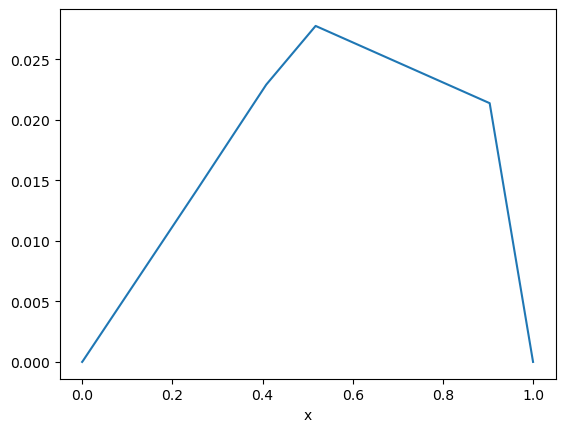

In [209]:
test_func = lambda x,a,b,c: x**2

M = 6
a = b = c = 1

xx = np.linspace(0,1,M+1)
xx,U = FEM_P1(test_func,a,b,c, M = M, show_A_F=True)

plt.plot(xx,U)
plt.xlabel('x')
plt.show()

In [178]:
def L2_and_H1_norm(u, N = 500):
    x = np.linspace(0,1,4*N)
    y = u(x)
    L2_squared = simpson(y = y**2,x = x)
    H1_squared = L2_squared + simpson(y = np.gradient(y,x)**2, x = x)
    return np.sqrt(L2_squared), np.sqrt(H1_squared)

In [179]:
def convergence(f,u,M,a,b,c, rho = 2): 
    P = 7
    Hconv = np.zeros(P)
    EconvL2 = np.zeros(P)
    EconvH1 = np.zeros(P)
    M_max = int(M*rho**P)

    for p in range(P):
        xx = np.linspace(0,1,M+1)
        H = np.diff(xx)
        _, U = FEM_P1(f,a,b,c,M = M, xx = xx)
        
        error_func = lambda x : u(x)-np.interp(x,xp = xx, fp = U)

        Hconv[p] = np.max(H)
        EconvL2[p], EconvH1[p] = L2_and_H1_norm(error_func, M_max)
        
        M = int(M*rho)
    
    orderL2 = np.polyfit(np.log(Hconv),np.log(EconvL2),1)[0]
    orderH1 = np.polyfit(np.log(Hconv),np.log(EconvH1),1)[0]
    return Hconv, EconvL2, orderL2, EconvH1, orderH1

In [180]:
def u_ex(x):
    return np.sin(3*np.pi*x)

def f(x,a,b,c):
    return 9*np.pi**2*a*np.sin(3*np.pi*x) + 3*np.pi*b*np.cos(3*np.pi*x)+c*np.sin(3*np.pi*x)

def u_ex2(x):
    return x*(1-x)

def f_2(x,a,b,c):
    return 2*a+b*(1-2*x)+c*x*(1-x)

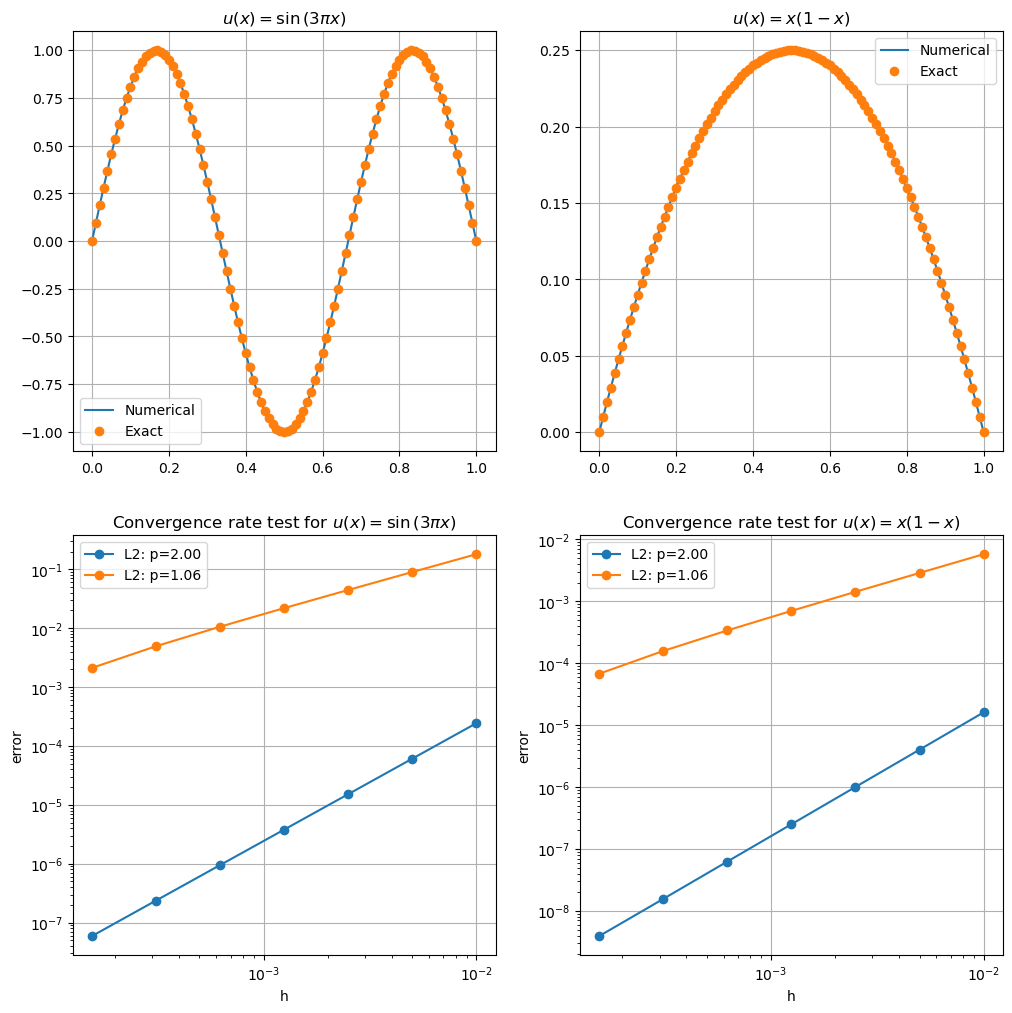

In [181]:
M = 100

a = 1
b = 1
c = 1

xx = np.linspace(0,1,M+1)

xx, U1 = FEM_P1(f,a,b,c, M = M, xx = xx)
xx, U2 = FEM_P1(f_2,a,b,c, M = M, xx = xx)

H1, E1L2, p1L2, E1H1, p1H1 = convergence(f,u_ex,M,a,b,c)
H2, E2L2, p2L2, E2H1, p2H1 = convergence(f_2,u_ex2,M,a,b,c)

fig,ax = plt.subplots(2,2, figsize = (12,12))
ax[0,0].plot(xx,U1,xx,u_ex(xx),'o')
ax[0,0].legend(['Numerical', 'Exact'])
ax[0,0].set_title('$u(x) = \sin{(3\pi x)}$')
ax[0,0].grid(True)

ax[0,1].plot(xx,U2,xx,u_ex2(xx),'o')
ax[0,1].legend(['Numerical', 'Exact'])
ax[0,1].set_title('$u(x) = x(1-x)$')
ax[0,1].grid(True)

ax[1,0].loglog(H1,E1L2,'o-', label='L2: p={:.2f}'.format(p1L2))
ax[1,0].loglog(H1,E1H1,'o-', label='L2: p={:.2f}'.format(p1H1))
ax[1,0].grid(True)
ax[1,0].set_xlabel('h')
ax[1,0].set_ylabel('error')
ax[1,0].set_title('Convergence rate test for $u(x) = \sin{(3\pi x)}$')
ax[1,0].legend()

ax[1,1].loglog(H2,E2L2,'o-', label='L2: p={:.2f}'.format(p2L2))
ax[1,1].loglog(H2,E2H1,'o-', label='L2: p={:.2f}'.format(p2H1))
ax[1,1].grid(True)
ax[1,1].set_xlabel('h')
ax[1,1].set_ylabel('error')
ax[1,1].set_title('Convergence rate test for $u(x) = x(1-x)$')
ax[1,1].legend()

plt.show()

In [182]:
def FEM_P1_non_smooth(F_func,a,b,c,g0 = 0, g1 = 0, xx = None,M = 100):
    
    U = np.zeros(M+1, dtype=np.float64)
    U[0] = g0
    U[-1] = g1

    if xx is None:
        xx = np.sort(np.concatenate((np.random.rand(M-1),[0,1]) ))
    
    H = np.diff(xx)

    A = np.zeros((M-1,M-1), dtype = np.float64)
    F = np.zeros(M-1, dtype = np.float64)
    
    A[0,0] = a/H[0]+(c/3)*H[0]
    A[-1,-1] = a/H[-1]+(c/3)*H[-1]
    F[0] = g0/H[0] + F_func(xx[0],xx[1],H[0],a,b,c)[1]
    F[-1] = g1/H[-1] + F_func(xx[-2],xx[-1],H[-1],a,b,c)[0]
    
    for i in range(M-2):
        h = H[i+1]
        
        A[i,i] += a/h+(c/3)*h
        A[i+1,i+1] += a/h+(c/3)*h
        A[i,i+1] += -a/h+0.5*b+(c/6)*h
        A[i+1,i] += -a/h-0.5*b+(c/6)*h
        
        deltaF = F_func(xx[i+1],xx[i+2],h,a,b,c)
        F[i] += deltaF[0]
        F[i+1] += deltaF[1]

    U[1:-1] = np.linalg.solve(A,F)
    
    return xx, U

In [183]:
def w1(x):
    val = np.zeros_like(x)
    val[x <= 0.5] = 2*x[x <= 0.5]
    val[x > 0.5] = 2*(1-x[x > 0.5])
    return val


def F_w1(x1,x2,h,a,b,c):
    diff_2 = x2**2-x1**2
    diff_3 = x2**3-x1**3

    if x1 < 0.5 and x2 <= 0.5:
        F_phi_1 = -a*h+b*(x2*h-0.5*diff_2) + c*(0.5*x2*diff_2-1/3*diff_3)
        F_phi_2 =  a*h+b*(-x1*h+0.5*diff_2) + c*(-0.5*x1*diff_2+1/3*diff_3)
    
    elif x1 >= 0.5 and x2 > 0.5:
        F_phi_1 = a*h-b*(x2*h-0.5*diff_2) + c*(x2*h-0.5*(1+x2)*diff_2 + 1/3*diff_3)
        F_phi_2 = -a*h-b*(0.5*diff_2-x1*h) + c*(0.5*(1+x1)*diff_2-x1*h-1/3*diff_3)
    
    elif x1 < 0.5 and x2 > 0.5:
        F_phi_1 = a*(x2+x1-1) + b*(-0.5*diff_2 + x2*(1-x1) - 0.25) + \
                  c*(1/24-1/6*x2**3 + 1/3*x1**3 - 0.5*x2*x1**2 + 0.5*x2**2 - 0.25*x2)
        F_phi_2 = a*(1-x2-x1) + b*(-0.5*diff_2 + x1*(x2-1)+0.25) + \
                  c*(-1/3*x2**3 + 1/6*x1**3+0.5*x1*x2**2 + 0.5*x2**2 - x1*x2 + 0.25*x1 - 1/24)
    
    return (2/h)*F_phi_1, (2/h)*F_phi_2


In [184]:
def w2(x):
    return x - x**(2/3)

def F_w2(x1,x2,h,a,b,c):
    diff_2 = x2**2-x1**2
    diff_3 = x2**3-x1**3
    diff_23 = x2**(2/3)-x1**(2/3)
    diff_53 = x2**(5/3)-x1**(5/3)
    diff_83 = x2**(8/3)-x1**(8/3)

    F_phi_1 = a*(diff_23 - h) + b*(x2*h - 0.5*diff_2 - x2*diff_23 + 2/5*diff_53) +\
              c*(0.5*x2*diff_2 - 1/3*diff_3 - 3/5*x2*diff_53 + 3/8 * diff_83)
    F_phi_2 = a*(h-diff_23) + b*(0.5*diff_2 - 2/5*diff_53 - x1*h + x1*diff_23) +\
              c*(1/3*diff_3 - 0.5*x1*diff_2 - 3/8*diff_83 + 3/5*x1*diff_53)
    
    return F_phi_1/h, F_phi_2/h

In [185]:
def convergence1(F,u,M,a,b,c, rho = 2): 
    P = 7
    Hconv = np.zeros(P)
    EconvL2 = np.zeros(P)
    EconvH1 = np.zeros(P)
    M_max = int(M*rho**P)

    for p in range(P):
        xx = np.linspace(0,1,M+1)
        H = np.diff(xx)
        _, U = FEM_P1_non_smooth(F,a,b,c,M = M, xx = xx)
        
        error_func = lambda x : u(x)-np.interp(x,xp = xx, fp = U)

        Hconv[p] = np.max(H)
        EconvL2[p], EconvH1[p] = L2_and_H1_norm(error_func, M_max)
        
        M = int(M*rho)
    
    orderL2 = np.polyfit(np.log(Hconv),np.log(EconvL2),1)[0]
    orderH1 = np.polyfit(np.log(Hconv),np.log(EconvH1),1)[0]
    return Hconv, EconvL2, orderL2, EconvH1, orderH1

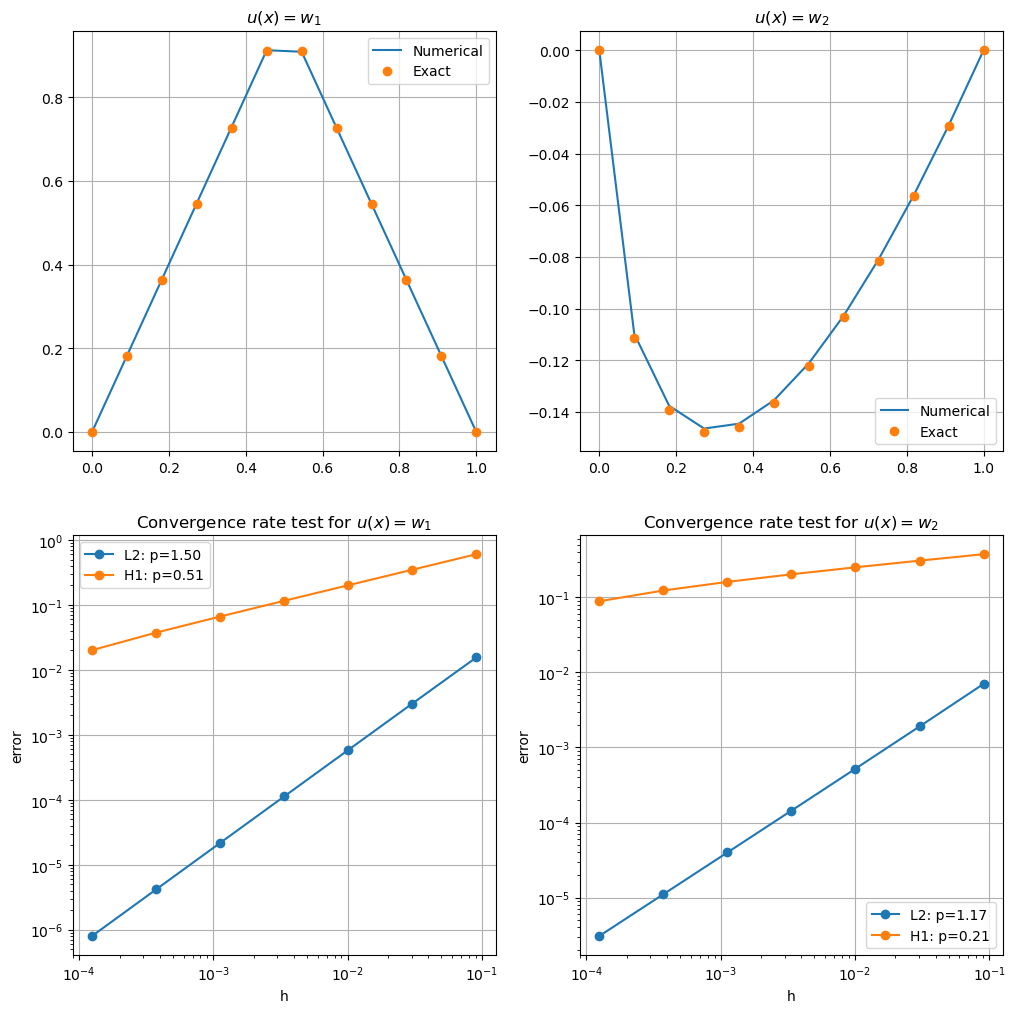

In [186]:
M = 11

a = 1
b = 1
c = 1

xx = np.linspace(0,1,M+1)

xx, U1 = FEM_P1_non_smooth(F_w1,a,b,c, M = M, xx = xx)
xx, U2 = FEM_P1_non_smooth(F_w2,a,b,c, M = M, xx = xx)

H1, E1L2, p1L2, E1H1, p1H1 = convergence1(F_w1,w1,M,a,b,c, rho = 3)
H2, E2L2, p2L2, E2H1, p2H1 = convergence1(F_w2,w2,M,a,b,c, rho = 3)

fig,ax = plt.subplots(2,2, figsize = (12,12))
ax[0,0].plot(xx,U1,xx,w1(xx),'o')
ax[0,0].legend(['Numerical', 'Exact'])
ax[0,0].set_title('$u(x) = w_1$')
ax[0,0].grid(True)

ax[0,1].plot(xx,U2,xx,w2(xx),'o')
ax[0,1].legend(['Numerical', 'Exact'])
ax[0,1].set_title('$u(x) = w_2$')
ax[0,1].grid(True)

ax[1,0].loglog(H1,E1L2,'o-', label='L2: p={:.2f}'.format(p1L2))
ax[1,0].loglog(H1,E1H1,'o-', label='H1: p={:.2f}'.format(p1H1))
ax[1,0].grid(True)
ax[1,0].set_xlabel('h')
ax[1,0].set_ylabel('error')
ax[1,0].set_title('Convergence rate test for $u(x) = w_1$')
ax[1,0].legend()

ax[1,1].loglog(H2,E2L2,'o-', label='L2: p={:.2f}'.format(p2L2))
ax[1,1].loglog(H2,E2H1,'o-', label='H1: p={:.2f}'.format(p2H1))
ax[1,1].grid(True)
ax[1,1].set_xlabel('h')
ax[1,1].set_ylabel('error')
ax[1,1].set_title('Convergence rate test for $u(x) = w_2$')
ax[1,1].legend()

plt.show()

In [187]:
def F(x1,x2,h,a,b,c):
    diff_34 = x2**(3/4)-x1**(3/4)
    diff_74 = x2**(7/4)-x2**(7/4)

    F_phi_1 = 4/3*x2*diff_34 - 7/4*diff_74
    F_phi_2 = 7/4*diff_74 - 4/3*x1*diff_34

    return F_phi_1/h, F_phi_2/h

In [219]:
M = 1000

a = 1
b = -100
c = 1

xx = np.linspace(0,1,M+1)

xx_exact, U_exact = FEM_P1_non_smooth(F,a,b,c, M = M, xx = xx)

U_func = lambda x: np.interp(x, xp = xx_exact, fp = U_exact)

In [220]:
M = 40

xx_non_even = np.concatenate(([0],np.logspace(0,3,M)*1e-3))
xx_even = np.linspace(0,1,M+1)

xx_non_even, U_non_even = FEM_P1_non_smooth(F,a,b,c, M = M, xx = xx_non_even)
xx_even, U_even = FEM_P1_non_smooth(F,a,b,c, M = M, xx = xx_even)

error_non_even = lambda x: U_func(x) - np.interp(x, xp = xx_non_even, fp = U_non_even)
error_even = lambda x: U_func(x) - np.interp(x, xp = xx_even, fp = U_even)

L2_error_non_even, H1_error_non_even =  L2_and_H1_norm(error_non_even, N = M)
L2_error_even, H1_error_even =  L2_and_H1_norm(error_even, N = M)

[]

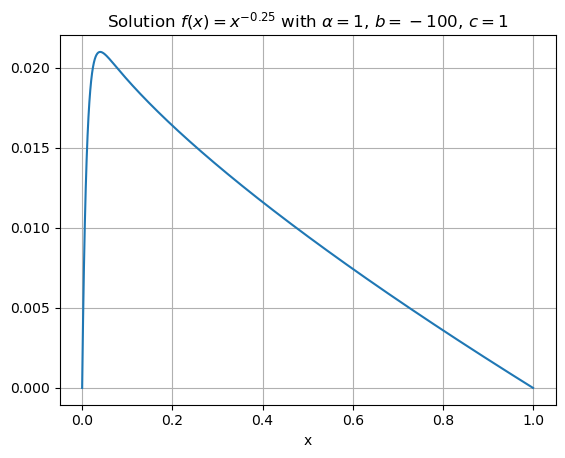

In [221]:
plt.plot(xx_exact, U_exact)
plt.xlabel('x')
plt.title(f'Solution $f(x) = x^{{{-0.25}}}$ with $\\alpha = {a}$, $b = {b}$, $c = {c}$')
plt.grid(True)
plt.plot()

[]

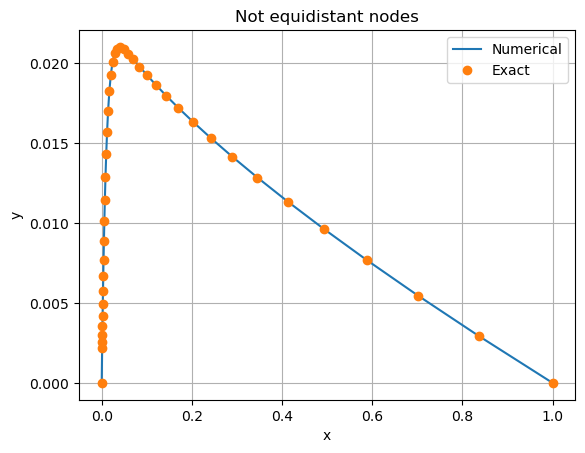

In [202]:
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.plot(xx_non_even,U_non_even,xx_non_even,U_func(xx_non_even), 'o')
plt.legend(['Numerical','Exact'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Not equidistant nodes')
plt.grid(True)

textstr_non_even = '\n'.join((
    r'$||e||_{L^2} = %.3e$' % (L2_error_non_even, ),
    r'$||e||_{H^1} = %.3e$' % (H1_error_non_even, )
    ))

plt.plot()

[]

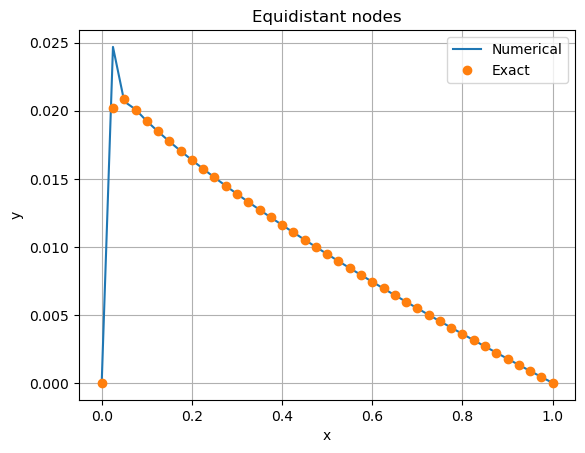

In [203]:
plt.plot(xx_even,U_even,xx_even,U_func(xx_even), 'o')
plt.legend(['Numerical','Exact'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Equidistant nodes')
plt.grid(True)

textstr_even = '\n'.join((
    r'$|| e ||_{L^2} = %.3e$' % (L2_error_even, ),
    r'$|| e||_{H^1} = %.3e$' % (H1_error_even, )
    ))
plt.plot()